In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")
from pymatreader import read_mat
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from iminuit import Minuit
from iminuit.cost import LeastSquares
import IPython
from pathlib import Path
from utilities import savefig, FK_fit, perform_fit, FitInput

plt.rc(
    "text.latex",
    preamble=r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{amsfonts}",
)

In [2]:
NB_NAME = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]).stem

In [3]:
DATAPATH = os.path.join(
    os.path.abspath(""), "data", "power_volt_sweep_old_dev"
)

sweep1 = os.path.join(
    DATAPATH,
    "VoltPowerScan_APD_Source_C1_SPhw_A248r66_first_Col2__931_20241031-113614_MIRA_Pulsed_1uW_50uW_0V_-4V.mat",
)
sweep2 = os.path.join(
    DATAPATH,
    "VoltPowerScan_APD_Source_C1_SPhw_A248r66_first_Col2__931_20241031-120027_MIRA_Pulsed_1uW_50uW_-4V_-7V.mat",
)
sweep3 = os.path.join(
    DATAPATH,
    "VoltPowerScan_APD_Source_C1_SPhw_A248r66_first_Col2__931_20241031-125939_MIRA_Pulsed_1uW_50uW_-7V_-8p5V.mat",

)

IV = os.path.join(DATAPATH, "IV_2024_10_31_8V.mat")
PS_M6V = os.path.join(DATAPATH, "Power_APD_Source_C1_SPhw_A248r66_first_Col2__931_20241101-141425_MIRA_Pulsed_318p2327THz_-6V1p000uW_200p000uW.mat")
PS_M7V = os.path.join(DATAPATH, "Power_APD_Source_C1_SPhw_A248r66_first_Col2__931_20241101-135851_MIRA_Pulsed_318p2327THz_-7V1p000uW_200p000uW.mat")
PS_M8V = os.path.join(DATAPATH, "Power_APD_Source_C1_SPhw_A248r66_first_Col2__931_20241101-143528_MIRA_Pulsed_318p2327THz_-8V1p000uW_200p000uW.mat")

In [4]:
data1 = read_mat(sweep1)["Data"]
data2 = read_mat(sweep2)["Data"]
data3 = read_mat(sweep3)["Data"]
IV_data = read_mat(IV)
PS_M6V_data = read_mat(PS_M6V)["Data"]
PS_M7V_data = read_mat(PS_M7V)["Data"]
PS_M8V_data = read_mat(PS_M8V)["Data"]


IV_V = IV_data["m_vlts"]
IV_I = IV_data["m_curr"] * 1e6

PS_M6V_P = PS_M6V_data["PowerMeasured"] * 1e6
PS_M6V_I = PS_M6V_data["MeasureCurrent"] * 1e6

PS_M7V_P = PS_M7V_data["PowerMeasured"] * 1e6
PS_M7V_I = PS_M7V_data["MeasureCurrent"] * 1e6

PS_M8V_P = PS_M8V_data["PowerMeasured"] * 1e6
PS_M8V_I = PS_M8V_data["MeasureCurrent"] * 1e6

/home/ali/miniconda3/envs/university/lib/python3.11/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


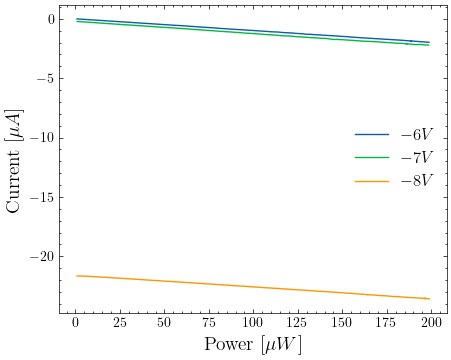

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xlabel(r"Power [$\mu W$]", fontsize=14)
ax.set_ylabel(r"Current [$\mu A$]", fontsize=14)
ax.plot(PS_M6V_P, PS_M6V_I, label=r"$-6V$")
ax.plot(PS_M7V_P, PS_M7V_I, label=r"$-7V$")
ax.plot(PS_M8V_P, PS_M8V_I, label=r"$-8V$")
ax.legend(frameon=False, fontsize=12)
# savefig(nb_name=NB_NAME, fig_name="P_I_realscan", fig=fig)

In [152]:
#["MeasuredPower", "MeasureCurrent", "VoltageList"]
voltages = np.concatenate((data1["VoltageList"], data2["VoltageList"][1:-1], data3["VoltageList"]),axis=0)
voltages = np.repeat(voltages.reshape(1, -1), 50, axis=0)
currents = np.hstack((data1["MeasureCurrent"], data2["MeasureCurrent"][:, 1:-1], data3["MeasureCurrent"])) * 1e6
powers = np.repeat(np.arange(1, 51), currents.shape[-1]).reshape(50, -1)
powers_measured = np.array(
    [data1["MeasuredPower"]] * len(data1["VoltageList"])
    + [data2["MeasuredPower"]] * len(data2["VoltageList"][1:-1])
    + [data3["MeasuredPower"]] * len(data3["VoltageList"])
).T * 1e6
currents_err = np.abs(currents * 0.00025) + 1e-6

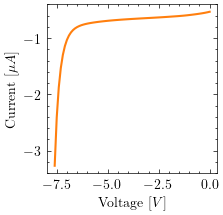

In [153]:
# fig, ax = plt.subplots(1, 1, figsize=(5, 4))
fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.2))
ax.set_xlabel(r"Voltage [$V$]", fontsize=10)
ax.set_ylabel(r"Current [$\mu A$]", fontsize=10)
# ax.plot(IV_V[:77], IV_I[:77], label=fr"IV-curve (no light)")
ax.plot(IV_V[:77], IV_I[:77], color="tab:orange", lw=1.5)
# ax.plot(voltages[0][:53], currents[0][:53], label=fr"{powers[:, 0][0]} $\mu W$")

# axins = zoomed_inset_axes(ax, zoom=3,loc=5)
# axins.plot(IV_V[:77], IV_I[:77], label=fr"IV-curve (no light)")
# axins.plot(voltages[0][:53], currents[0][:53], label=fr"{powers[:, 0][0]} $\mu W$")
# axins.set_xlim(-7.5, -6.5)
# axins.set_ylim(-1.4, -0.9)
# mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")
# plt.xticks(visible=False)
# plt.yticks(visible=False)

# ax.legend(frameon=False, fontsize=12)
# savefig(NB_NAME, "IV_dark", fig)
# savefig(NB_NAME, "IV_dark", fig, svg=True)

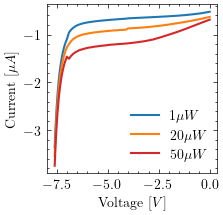

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.2))
ax.set_xlabel(r"Voltage [$V$]", fontsize=10)
ax.set_ylabel(r"Current [$\mu A$]", fontsize=10)
ax.plot(voltages[0][:53], currents[0][:53], label=fr"{powers[:, 0][0]}$\mu W$", color="tab:blue", lw=1.5)
ax.plot(voltages[19][:53], currents[19][:53], label=fr"{powers[:, 0][19]}$\mu W$", color="tab:orange", lw=1.5)
ax.plot(voltages[-1][:53], currents[-1][:53], label=fr"{powers[:, 0][-1]}$\mu W$", color="tab:red", lw=1.5)
ax.legend(frameon=False, fontsize=10)
# savefig(NB_NAME, "IV_powers", fig, svg=True)

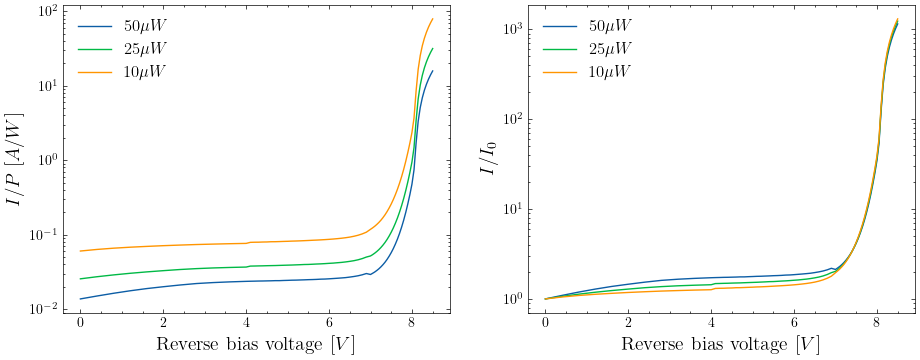

In [155]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(11, 4))
ax.set_xlabel(r"Reverse bias voltage [$V$]", fontsize=14)
ax.set_ylabel(r"$I / P$ [$A/W$]", fontsize=14)
ax.plot(-voltages[49], -currents[49] / powers[:, 0][49], label=f"{powers[:, 0][49]}$\mu W$")
ax.plot(-voltages[24], -currents[24] / powers[:, 0][24], label=f"{powers[:, 0][24]}$\mu W$")
ax.plot(-voltages[9], -currents[9] / powers[:, 0][9], label=f"{powers[:, 0][9]}$\mu W$")
ax.set_yscale("log")
ax.legend(frameon=False, fontsize=12)

ax1.set_xlabel(r"Reverse bias voltage [$V$]", fontsize=14)
ax1.set_ylabel(r"$I/I_0$", fontsize=14)
ax1.plot(-voltages[49], currents[49] / currents[49][0], label=f"{powers[:, 0][49]}$\mu W$")
ax1.plot(-voltages[24], currents[24] / currents[24][0], label=f"{powers[:, 0][24]}$\mu W$")
ax1.plot(-voltages[9], currents[9] / currents[9][0], label=f"{powers[:, 0][9]}$\mu W$")
ax1.set_yscale("log")
ax1.legend(frameon=False, fontsize=12)

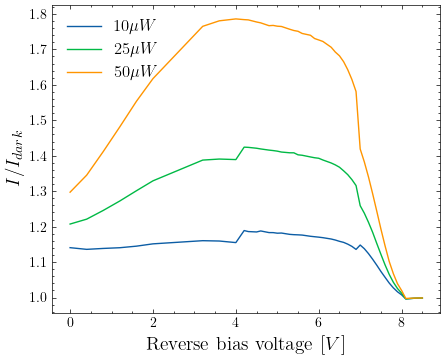

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.set_xlabel(r"Reverse bias voltage [$V$]", fontsize=14)
ax.set_ylabel(r"$I/I_{{dark}}$", fontsize=14)
for idx in [9, 24, 49]:
    ax.plot(
        -voltages[idx][np.isin(voltages[idx],IV_V)],
        currents[idx][np.isin(voltages[idx],IV_V)] / IV_I[np.isin(IV_V,voltages[idx])],
        label=f"{powers[:, 0][idx]}$\mu W$"
    )
ax.legend(frameon=False, fontsize=12)
# savefig(NB_NAME, "I_Idark_ratio_powers", fig)

(-1.46, -0.6)

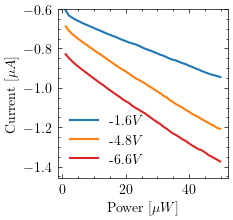

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.2))
ax.set_xlabel(r"Power [$\mu W$]", fontsize=10)
ax.set_ylabel(r"Current [$\mu A$]", fontsize=10)
colors = ["tab:red", "tab:orange", "tab:blue"][::-1]
for color_idx, idx in enumerate([4, 18, 36]):
    ax.plot(powers_measured[:, idx], currents[:,idx], label=f"{voltages[0][idx]}$V$", color=colors[color_idx], lw=1.5)
ax.legend(frameon=False, fontsize=10)
ax.set_ylim(-1.46, -0.6)
# savefig(NB_NAME, "P_I_curves", fig, svg=True)

In [228]:
def current_error_from_power_error(current, power, power_measured):
    # return np.abs(np.gradient(current) * np.abs(power - power_measured))
    return np.abs(np.gradient(current) * np.abs(power - power_measured).max())

In [229]:
currents_err

array([[1.31384436e-04, 1.39081631e-04, 1.44472519e-04, ...,
        1.53751138e-01, 1.75858553e-01, 1.97875557e-01],
       [1.42883518e-04, 1.49124684e-04, 1.53462775e-04, ...,
        1.53742625e-01, 1.75856195e-01, 1.97870231e-01],
       [1.44988402e-04, 1.51296188e-04, 1.55810422e-04, ...,
        1.53736411e-01, 1.75849079e-01, 1.97858866e-01],
       ...,
       [1.72015728e-04, 1.87871219e-04, 2.04373716e-04, ...,
        1.53771743e-01, 1.75882069e-01, 1.97898403e-01],
       [1.72332033e-04, 1.88560047e-04, 2.04729414e-04, ...,
        1.53769488e-01, 1.75876495e-01, 1.97896744e-01],
       [1.72699085e-04, 1.88803252e-04, 2.05397850e-04, ...,
        1.53773737e-01, 1.75884863e-01, 1.97898360e-01]])

In [250]:
current_error_from_power_error(currents[:, 10], data1["PowerList"] * 1e6, powers_measured[:, 10])

array([0.00420296, 0.00419031, 0.00384048, 0.00336882, 0.00345695,
       0.00363013, 0.00324191, 0.00322816, 0.00329558, 0.00316833,
       0.00318812, 0.00313651, 0.00318688, 0.00301126, 0.00322549,
       0.00380053, 0.00326792, 0.0030903 , 0.00305276, 0.00296866,
       0.00264577, 0.00250672, 0.0032226 , 0.00335297, 0.00377111,
       0.00345263, 0.00274669, 0.00317145, 0.00326523, 0.00340182,
       0.00363745, 0.0033626 , 0.00325964, 0.00285241, 0.00289409,
       0.00296832, 0.00307573, 0.00354163, 0.00350196, 0.00391623,
       0.00348122, 0.00373791, 0.00362694, 0.00227492, 0.00268247,
       0.00294935, 0.00277401, 0.00282043, 0.00285931, 0.00279872])

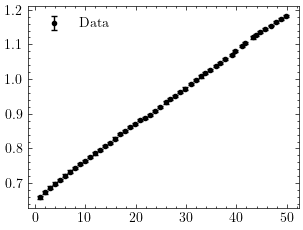

In [234]:
plt.errorbar(powers_measured[:, 10], -currents[:, 10], yerr=current_error_from_power_error(currents[:, 10], data1["PowerList"] * 1e6, powers_measured[:, 10]), fmt=".k", capsize=2, label="Data")
plt.legend()

In [190]:
from scipy.stats import chi2

0.0


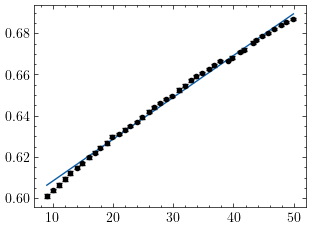

-0.4


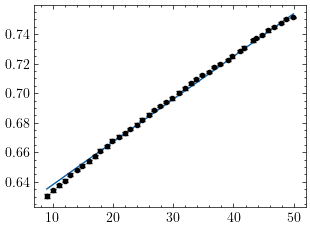

-0.8


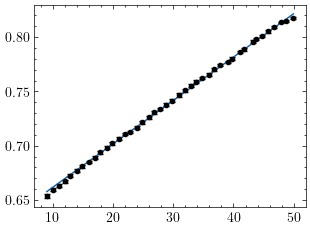

-1.2000000000000002


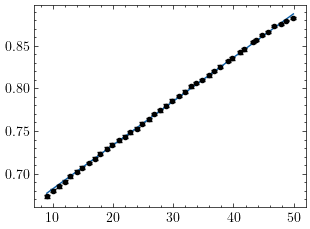

-1.6


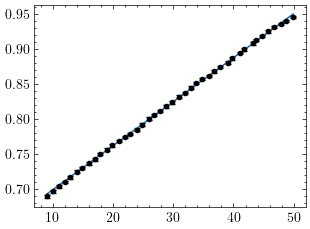

-2.0


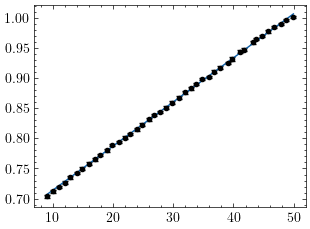

-2.4


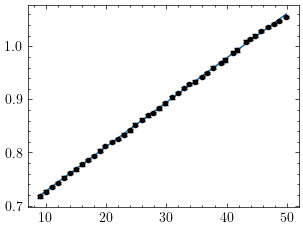

-2.8


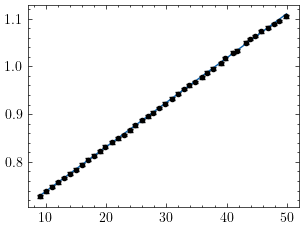

-3.2


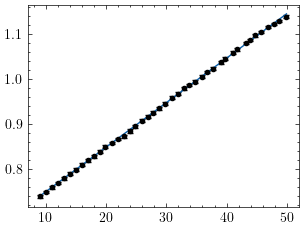

-3.6


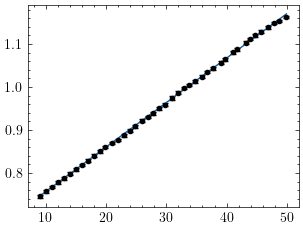

-4.0


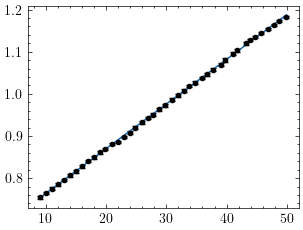

-4.1


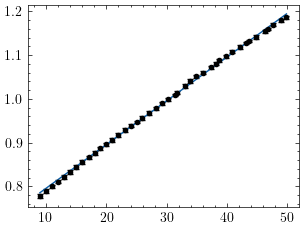

-4.2


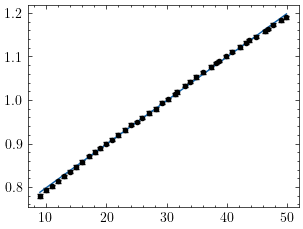

-4.3


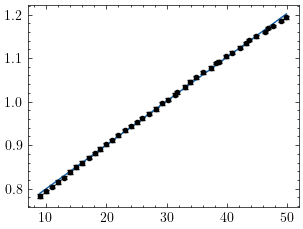

-4.4


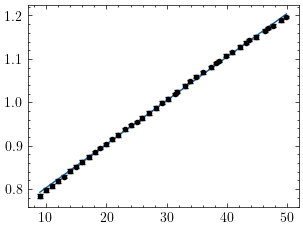

-4.5


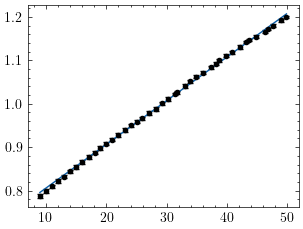

-4.6


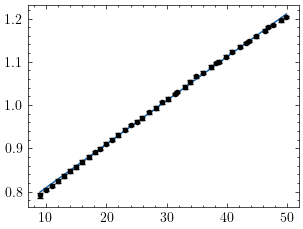

-4.7


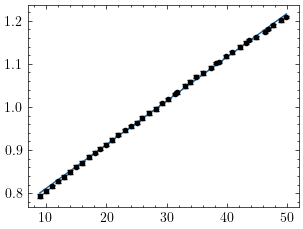

-4.8


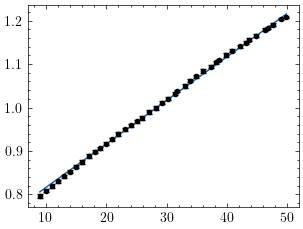

-4.9


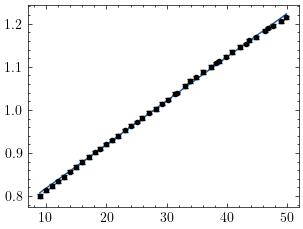

-5.0


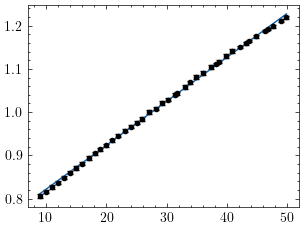

-5.1


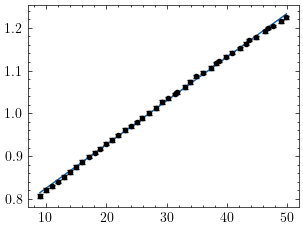

-5.2


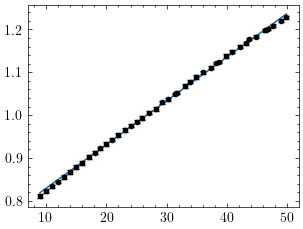

-5.3


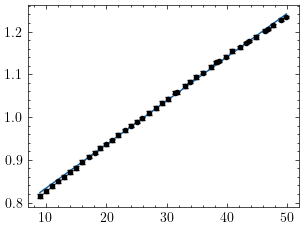

-5.4


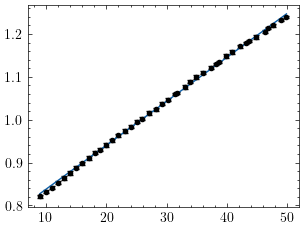

-5.5


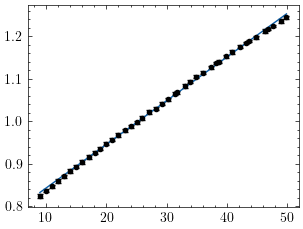

-5.6


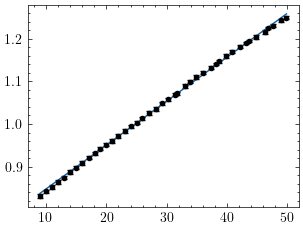

-5.7


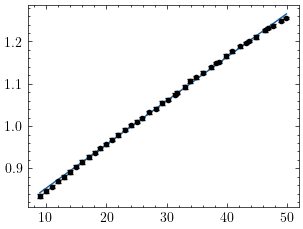

-5.8


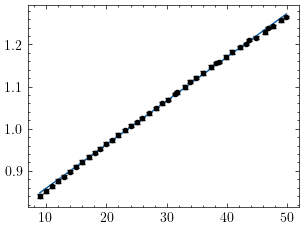

-5.9


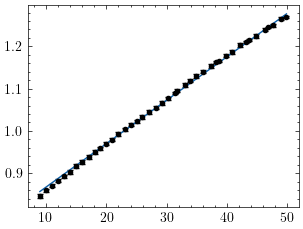

-6.0


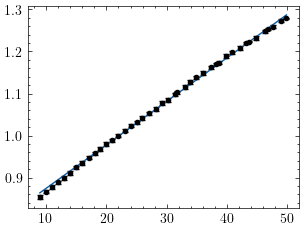

-6.1


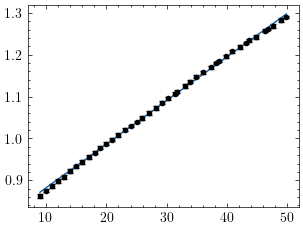

-6.2


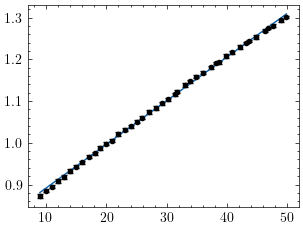

-6.3


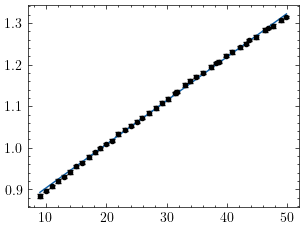

-6.4


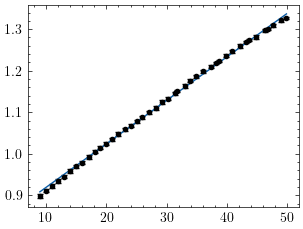

-6.5


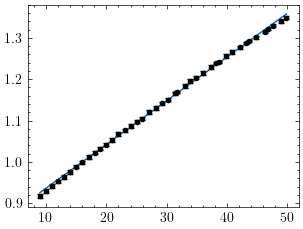

-6.6


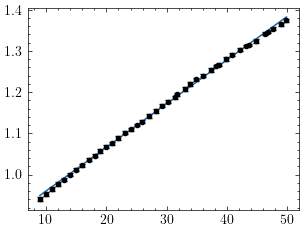

-6.7


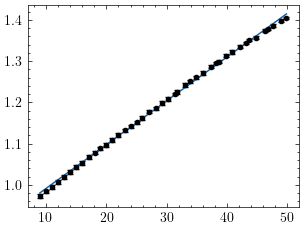

-6.8


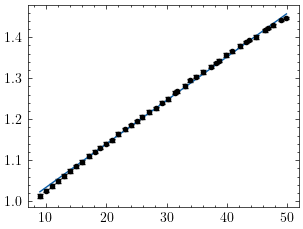

-6.9


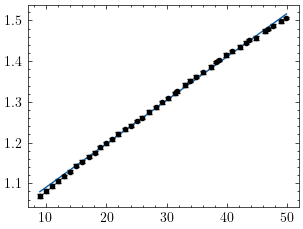

-7.0


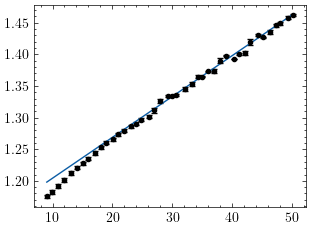

-7.05


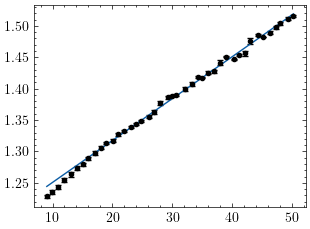

-7.1


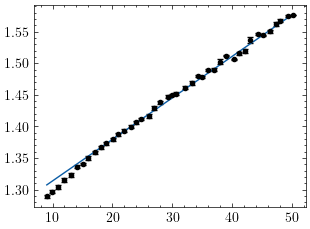

-7.15


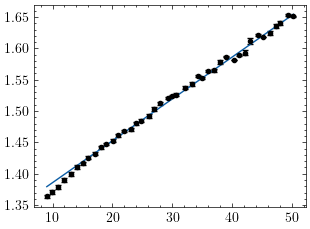

-7.2


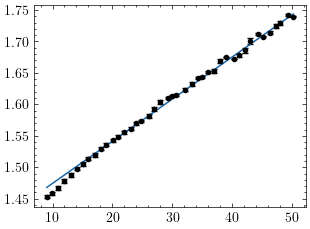

-7.25


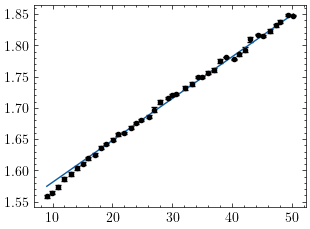

-7.3


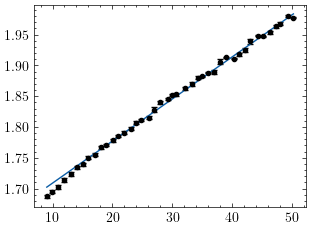

-7.35


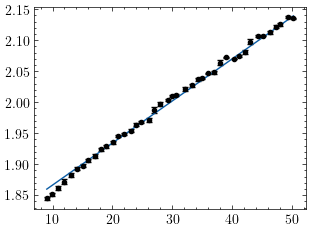

-7.4


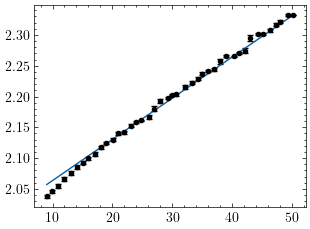

-7.45


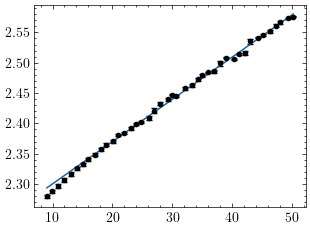

-7.5


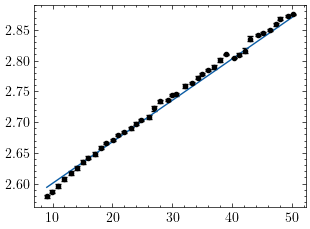

-7.55


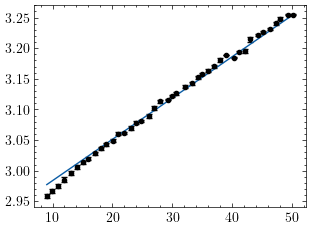

-7.6


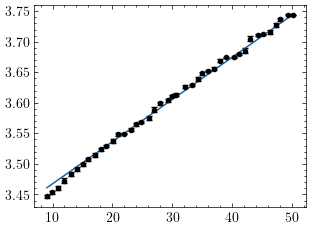

-7.65


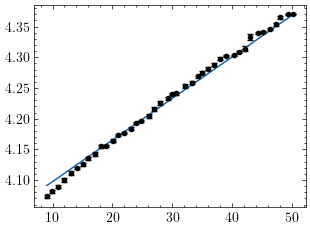

-7.7


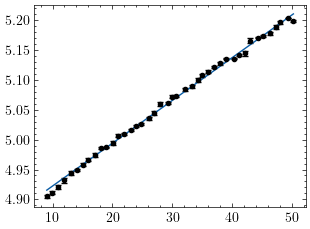

-7.75


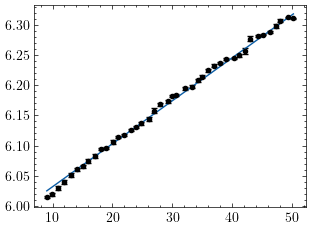

-7.8


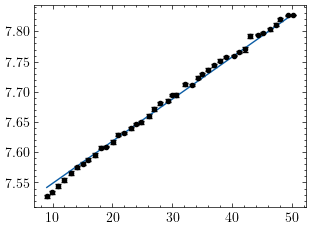

-7.85


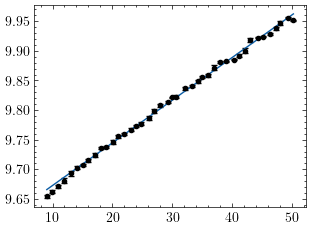

-7.9


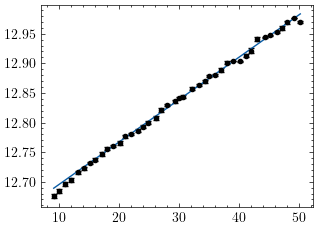

-7.95


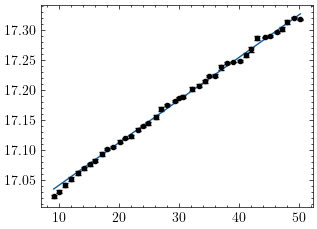

-8.0


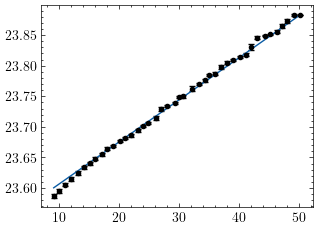

-8.05


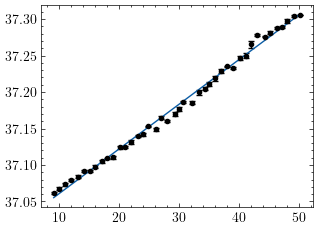

-8.1


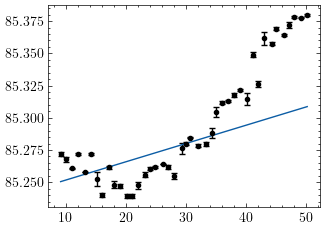

-8.15


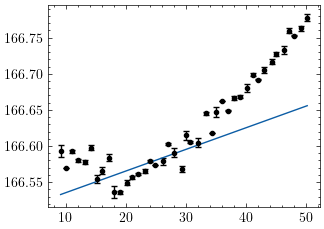

-8.2


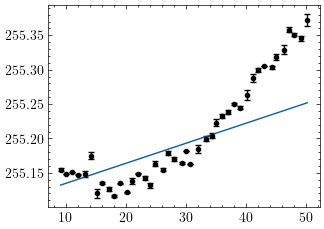

-8.25


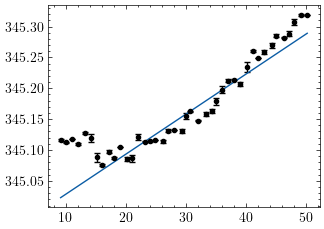

-8.3


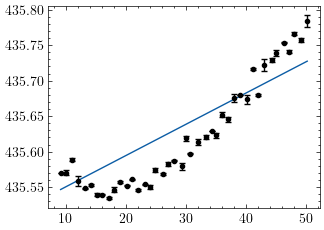

-8.35


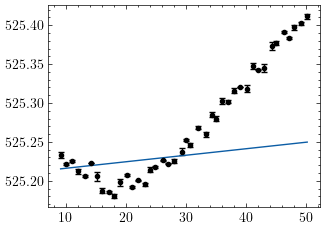

-8.4


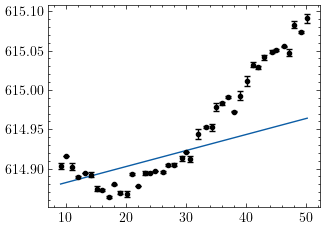

-8.45


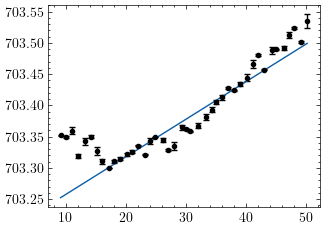

-8.5


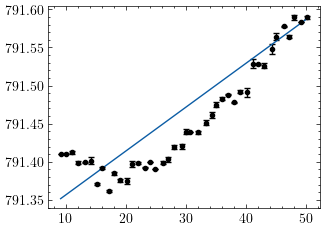

In [272]:
I_0_vals = []
res_vals = []
I_0_errs = []
res_errs = []

tail_idx = 8
for idx in range(currents.shape[1]):
    P_I_lstsq = LeastSquares(
        powers_measured[:, idx][tail_idx:],
        -currents[:, idx][tail_idx:],
        current_error_from_power_error(
            currents[:, idx][tail_idx:],
            data1["PowerList"][tail_idx:] * 1e6,
            powers_measured[:, idx][tail_idx:],
        ),
        model=lambda pow, I_0, res: pow * res + I_0,
    )
    P_I_minuit = Minuit(P_I_lstsq, I_0=-3, res=0.05)
    P_I_minuit.migrad()
    P_I_minuit.hesse()

    I_0_fit, res_fit = P_I_minuit.values[:]
    I_0_fit_err, res_fit_err = P_I_minuit.errors[:]

    I_0_vals.append(I_0_fit)
    res_vals.append(res_fit)

    I_0_errs.append(I_0_fit_err)
    res_errs.append(res_fit_err)

    if not P_I_minuit.accurate or not P_I_minuit.valid:
        print("NOTE: Error occured.")

    print(voltages[0, idx])
    plt.errorbar(
        powers_measured[:, idx][tail_idx:],
        -currents[:, idx][tail_idx:],
        yerr=current_error_from_power_error(
            currents[:, idx][tail_idx:], data1["PowerList"][tail_idx:] * 1e6, powers_measured[:, idx][tail_idx:]
        ),
        fmt=".k",
        capsize=2,
    )
    plt.plot(
        powers_measured[:, idx][tail_idx:],
        powers_measured[:, idx][tail_idx:] * res_fit + I_0_fit,
    )
    plt.show()

I_0_vals = np.array(I_0_vals)
res_vals = np.array(res_vals)
I_0_errs = np.array(I_0_errs)
res_errs = np.array(res_errs)

<ErrorbarContainer object of 3 artists>

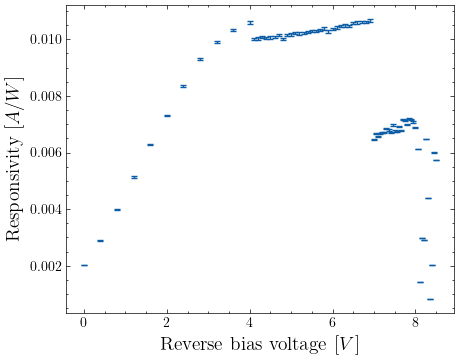

In [273]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xlabel(r"Reverse bias voltage [$V$]", fontsize=14)
ax.set_ylabel(r"Responsivity [$A/W$]", fontsize=14)
# ax.plot(-voltages[0], res_vals)
ax.errorbar(-voltages[0], res_vals, res_errs, fmt="None", capsize=2)
# savefig(NB_NAME, "responsivity_bias", fig)

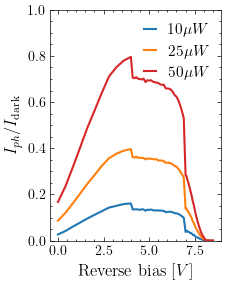

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2.2, 3))
ax.set_xlabel(r"Reverse bias [$V$]", fontsize=12)
ax.set_ylabel(r"$I_{ph}/I_{\mathrm{dark}}$", fontsize=12)

colors = ["tab:blue", "tab:orange", "tab:red"]
for color_idx, idx in enumerate([9, 24, 49]):
    ax.plot(
        -voltages[idx],
        -(currents[idx] + I_0_vals) / I_0_vals,
        label=f"{powers[:, 0][idx]}$\mu W$",
        lw=1.5,
        color=colors[color_idx]
    )

ax.legend(frameon=False, fontsize=11, handlelength=0.8, loc="upper right")
ax.set_ylim(0, 1.0)
# savefig(NB_NAME, "I_ph_I_dark", fig, svg=True)

In [319]:
def responsivity_voltage_fit(V_d: np.ndarray, eta: float, g: float, alpha_0: float):
    alpha = FK_fit(931, 0, 298, V_d)
    res = eta / 1.24 * (931 / 1000)
    return res * (1 - np.exp(-3.5e-3 * (g * alpha + alpha_0)))

In [320]:
# res_upper_idx = 40
res_upper_idx = 11
res_fit_result = perform_fit(FitInput(voltages[0][:res_upper_idx], res_vals[:res_upper_idx], res_errs[:res_upper_idx], responsivity_voltage_fit, [0.01, 0.4, 50]))

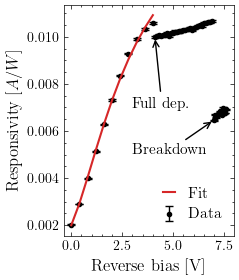

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2.2, 3))
pars = res_fit_result.parameters
ax.errorbar(
    np.abs(voltages[0])[:53],
    res_vals[:53],
    res_errs[:53],
    fmt=".k",
    label="Data",
    capsize=3,
    zorder=0,
)
ax.plot(
    np.abs(voltages[0][:res_upper_idx]),
    responsivity_voltage_fit(voltages[0][:res_upper_idx], *res_fit_result.parameters),
    label="Fit",
    lw=1.5,
    color="tab:red",
)
ax.set_xlabel(r"Reverse bias [V]", fontsize=12)
ax.set_ylabel(r"Responsivity [$A/W$]", fontsize=12)
# ax.arrow(4, 0.008, np.abs(voltages[0])[res_upper_idx] - 4, res_vals[res_upper_idx] - 0.008, zorder=2)
# ax.annotate(
#     "Breakdown",
#     xytext=(4, 0.004),
#     xy=(np.abs(voltages[0])[res_upper_idx], res_vals[res_upper_idx]),
#     arrowprops=dict(arrowstyle="->"),
#     fontsize=12
# )
ax.annotate(
    r"Breakdown",
    xytext=(3, 0.005),
    xy=(np.abs(voltages[0])[40], res_vals[40]),
    arrowprops=dict(arrowstyle="->"),
    fontsize=11
)

ax.annotate(
    r"Full dep.",
    xytext=(3, 0.007),
    xy=(np.abs(voltages[0])[11], res_vals[11]),
    arrowprops=dict(arrowstyle="->"),
    fontsize=11
)

ax.legend(frameon=False, fontsize=11, handlelength=0.8)
# savefig(NB_NAME, "res_bias_fit", fig, svg=True)
plt.show()

In [324]:
print(f"eta from responsivity fit: {pars[0]} ± {res_fit_result.parameter_errors[0]}")
print(f"Gamma from responsivity fit: {pars[1]} ± {res_fit_result.parameter_errors[1]}")
print(f"alpha_0 from responsivity fit: {pars[2]} ± {res_fit_result.parameter_errors[2]}")

eta from responsivity fit: 0.020484898206584647 ± 0.0001872264503470212
Gamma from responsivity fit: 0.34962551056449565 ± 0.005344001216152951
alpha_0 from responsivity fit: 23.303562882740053 ± 0.18318860877731183
